In [1]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from mhcflurry.amino_acid import common_amino_acids
from mhcflurry import dataset
from mhcflurry.dataset import Dataset
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns

Using Theano backend.


In [2]:
ds = Dataset.from_csv("bdata.2009.mhci.public.1.txt")
ds_h = ds.slice(ds.alleles == 'HLA-A0201')

In [5]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")

df['log_meas']=1-np.log(df['meas'])/math.log(50000)
df['peptide_length'] = df['sequence'].str.len()


max_len=df['sequence'].str.len().max()
n_peptides = df['sequence'].count()

def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df['hotshot_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_hotshot_encoding(seq))

def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df['index_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_index_encoding(seq, max_len))

def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

df['affinity_label'] = affinity_label(df['log_meas'])
df_h = df[df['mhc']=='HLA-A-0201'][['hotshot_encoded_peptides','index_encoded_peptides','log_meas','peptide_length']]
X = np.array(list(df_h['index_encoded_peptides']))
y = np.array(list(df_h['log_meas']))
y[y<0]=0

In [6]:
def regroup_together(affinities, weights , original_indices):
    affinities = affinities.ravel()
    weights = weights.ravel()
    assert affinities.shape == weights.shape, "%s should be %s" % (affinities.shape, weights.shape)
    assert affinities.shape == original_indices.shape
    assert len(affinities) == len(affinities.ravel())
    weighted_affinities = (affinities * weights)
    index_set = set(original_indices)
    n_indices = len(index_set)
    result_order = {original_index: i for (i, original_index) in enumerate(sorted(index_set))}
    result = np.zeros(n_indices)
    for i, x in enumerate(weighted_affinities):
        result_idx = result_order[original_indices[i]]
        result[result_idx] += x
    return result

In [8]:
def slicing(dataset,index, i):
    return dataset.slice(index).kmer_index_encoding()[i]
def label_transform(array):
    result = 1-np.log(array)/math.log(50000)
    result[result<0]=0
    return result

In [9]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

n_epochs = 40
epoch = 0

train_nn_aucs = np.zeros((folds,n_epochs))
test_nn_aucs = np.zeros((folds,n_epochs))

train_lstm_aucs = np.zeros((folds,n_epochs))
test_lstm_aucs = np.zeros((folds,n_epochs))

for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):

    
    nn = Sequential()
    nn.add(Embedding(input_dim = 21, input_length =9, output_dim= 32))
    nn.add(Flatten())
    nn.add(Dense(10, init='glorot_uniform', activation='sigmoid'))
    nn.add(Dense(1, init='glorot_uniform', activation='sigmoid'))
    
    nn.compile(optimizer = 'adam', loss='mean_squared_error')
    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm = Model(input = sequence, output = output)
    
    lstm.compile(optimizer = 'adam', loss='mean_squared_error')
    
    X_train = slicing(ds_h,train_idx,0)
    y_train = label_transform(slicing(ds_h,train_idx,1))
    
    X_test = slicing(ds_h,test_idx,0)
    y_test = label_transform(slicing(ds_h,test_idx,1))
    
    weights_train = slicing(ds_h,train_idx,2)
    weights_test = slicing(ds_h,test_idx,2)
    
    original_indices_train = slicing(ds_h,train_idx,3)
    original_indices_test = slicing(ds_h,test_idx,3)
    
    train_real_labels = regroup_together(y_train, weights_train , original_indices_train)
    test_real_labels = regroup_together(y_test, weights_test , original_indices_test)
    
    
    for epoch in range(n_epochs):
        # nn
        nn.fit(X_train,y_train, sample_weight = weights_train, batch_size = batch_size_nn, nb_epoch=1)
        
        train_pred_grouped = regroup_together(nn.predict(X_train), weights_train, original_indices_train)
        test_pred_grouped = regroup_together(nn.predict(X_test), weights_test, original_indices_test)
        
        train_nn_auc = roc_auc_score(measured_affinity_less_than(train_real_labels,500), train_pred_grouped)     
        test_nn_auc = roc_auc_score(measured_affinity_less_than(test_real_labels,500), test_pred_grouped)
        
        train_nn_aucs[i][epoch]=train_nn_auc
        test_nn_aucs[i][epoch]=test_nn_auc
        print("NN: ", train_nn_auc, test_nn_auc, epoch)
        #lstm 
        lstm.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        
        train_lstm_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm.predict(X[train_idx]))
        test_lstm_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm.predict(X[test_idx]))
        
        train_lstm_aucs[i][epoch]=train_lstm_auc
        test_lstm_aucs[i][epoch]=test_lstm_auc
        print("LSTM: ", train_lstm_auc, test_lstm_auc, epoch)
train_nn_aucs_mean = np.mean(train_nn_aucs, axis=0)
test_nn_aucs_mean = np.mean(test_nn_aucs, axis=0)
train_lstm_aucs_mean=np.mean(train_lstm_aucs, axis=0)
test_lstm_aucs_mean = np.mean(test_lstm_aucs, axis=0)

Epoch 1/1
22353/22353 [==============================] - 1s - loss: 0.0143     
NN:  0.941052189 0.942700839665 0
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0598    
LSTM:  0.871869813715 0.86208403829 0
Epoch 1/1
22353/22353 [==============================] - 1s - loss: 0.0087     
NN:  0.948585558721 0.947640097475 1
Epoch 1/1
6376/6376 [==============================] - 10s - loss: 0.0481    
LSTM:  0.89001371176 0.881124818806 1
Epoch 1/1
22353/22353 [==============================] - 1s - loss: 0.0083     
NN:  0.950419673048 0.950331871811 2
Epoch 1/1
6376/6376 [==============================] - 10s - loss: 0.0441    
LSTM:  0.909123423591 0.903070094737 2
Epoch 1/1
22353/22353 [==============================] - 1s - loss: 0.0082     
NN:  0.951499307756 0.951642305466 3
Epoch 1/1
6376/6376 [==============================] - 10s - loss: 0.0378    
LSTM:  0.933314141307 0.931191462435 3
Epoch 1/1
22353/22353 [==============================] - 1s - loss: 0

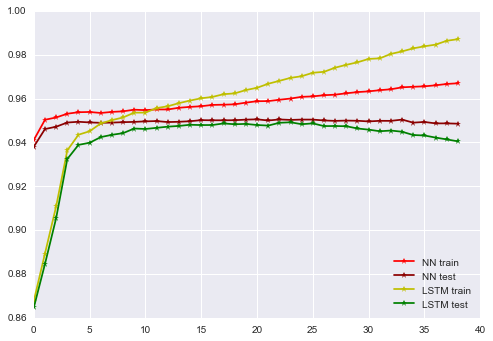

In [37]:
plt.plot(np.arange(0,n_epochs-1,1), train_nn_aucs_mean[0:n_epochs-1], color= 'r', marker='*', linestyle='-', label ="NN train")
plt.plot(np.arange(0,n_epochs-1,1), test_nn_aucs_mean[0:n_epochs-1],color='darkred',marker='*', linestyle='-',label ="NN test")
plt.plot(np.arange(0,n_epochs-1,1), train_lstm_aucs_mean[0:n_epochs-1], color='y',marker='*', linestyle='-', label ="LSTM train")
plt.plot( np.arange(0,n_epochs-1,1), test_lstm_aucs_mean[0:n_epochs-1],color='green',marker='*', linestyle='-', label ="LSTM test")
plt.legend( loc=4)

# Regularization on LSTM 

In [38]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

n_epochs = 40
epoch = 0

train_lstm10_aucs = np.zeros((folds,n_epochs))
test_lstm10_aucs = np.zeros((folds,n_epochs))


train_lstm01_aucs = np.zeros((folds,n_epochs))
test_lstm01_aucs = np.zeros((folds,n_epochs))


train_lstm11_aucs = np.zeros((folds,n_epochs))
test_lstm11_aucs = np.zeros((folds,n_epochs))


train_lstm00_aucs = np.zeros((folds,n_epochs))
test_lstm00_aucs = np.zeros((folds,n_epochs))

for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm00 = Model(input = sequence, output = output)
    
    lstm00.compile(optimizer = 'adam', loss='mean_squared_error')

    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden, dropout_W = 0.5)(embedded)
    backwards = LSTM(hidden, dropout_W = 0.5, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm10 = Model(input = sequence, output = output)
    
    lstm10.compile(optimizer = 'adam', loss='mean_squared_error')
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden, dropout_U = 0.5)(embedded)
    backwards = LSTM(hidden, dropout_U = 0.5, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm01 = Model(input = sequence, output = output)
    
    lstm01.compile(optimizer = 'adam', loss='mean_squared_error')
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden, dropout_W = 0.5, dropout_U = 0.5)(embedded)
    backwards = LSTM(hidden, dropout_W = 0.5,dropout_U = 0.5, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm11 = Model(input = sequence, output = output)
    
    lstm11.compile(optimizer = 'adam', loss='mean_squared_error')
    
    for epoch in range(n_epochs):

        #lstm00 
        lstm00.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        
        train_lstm00_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm00.predict(X[train_idx]))
        test_lstm00_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm00.predict(X[test_idx]))
        
        train_lstm00_aucs[i][epoch]=train_lstm00_auc
        test_lstm00_aucs[i][epoch]=test_lstm00_auc
        
        #lstm10 
        lstm10.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        train_lstm10_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm10.predict(X[train_idx]))
        test_lstm10_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm10.predict(X[test_idx]))
        
        train_lstm10_aucs[i][epoch]=train_lstm10_auc
        test_lstm10_aucs[i][epoch]=test_lstm10_auc
        
        
        #lstm01
        lstm01.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        train_lstm01_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm01.predict(X[train_idx]))
        test_lstm01_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm01.predict(X[test_idx]))
        
        train_lstm01_aucs[i][epoch]=train_lstm01_auc
        test_lstm01_aucs[i][epoch]=test_lstm01_auc
        
        #lstm11 
        lstm11.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        train_lstm11_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm11.predict(X[train_idx]))
        test_lstm11_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm11.predict(X[test_idx]))
        
        train_lstm11_aucs[i][epoch]=train_lstm11_auc
        test_lstm11_aucs[i][epoch]=test_lstm11_auc
        
        print(test_lstm00_auc, test_lstm01_auc, test_lstm10_auc,test_lstm11_auc, epoch, i)
        
train_lstm00_aucs_mean = np.mean(train_lstm00_aucs, axis=0)
test_lstm00_aucs_mean = np.mean(test_lstm00_aucs, axis=0)

train_lstm01_aucs_mean = np.mean(train_lstm01_aucs, axis=0)
test_lstm01_aucs_mean = np.mean(test_lstm01_aucs, axis=0)

train_lstm10_aucs_mean = np.mean(train_lstm10_aucs, axis=0)
test_lstm10_aucs_mean = np.mean(test_lstm10_aucs, axis=0)

train_lstm11_aucs_mean = np.mean(train_lstm11_aucs, axis=0)
test_lstm11_aucs_mean = np.mean(test_lstm11_aucs, axis=0)

Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0597    
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0648    
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0671    
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0703    
0.865074174893 0.850961280824 0.858231174255 0.850346146475 0 0
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0490    
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0516    
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0547    
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0567    
0.883775258202 0.863277137893 0.875641133936 0.857437789458 1 0
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0443    
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0457    
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0516    
Epoch 1/1
6376

## Plot on test set 

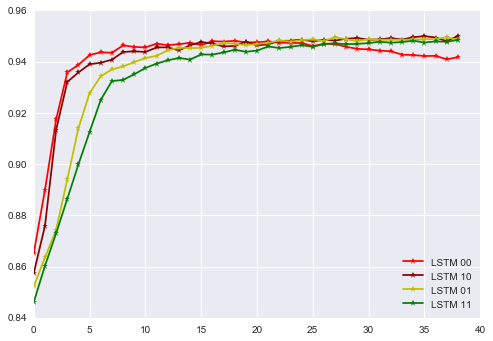

In [40]:
plt.plot(np.arange(0,n_epochs-1,1), test_lstm00_aucs_mean[0:n_epochs-1], color= 'r', marker='*', linestyle='-', label ="LSTM 00")
plt.plot(np.arange(0,n_epochs-1,1), test_lstm10_aucs_mean[0:n_epochs-1],color='darkred',marker='*', linestyle='-',label ="LSTM 10")
plt.plot(np.arange(0,n_epochs-1,1), test_lstm01_aucs_mean[0:n_epochs-1], color='y',marker='*', linestyle='-', label ="LSTM 01")
plt.plot( np.arange(0,n_epochs-1,1), test_lstm11_aucs_mean[0:n_epochs-1],color='green',marker='*', linestyle='-', label ="LSTM 11")
plt.legend( loc=4)

## Plot on training set

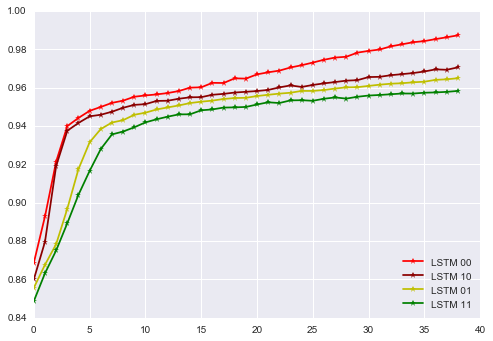

In [41]:
plt.plot(np.arange(0,n_epochs-1,1), train_lstm00_aucs_mean[0:n_epochs-1], color= 'r', marker='*', linestyle='-', label ="LSTM 00")
plt.plot(np.arange(0,n_epochs-1,1), train_lstm10_aucs_mean[0:n_epochs-1],color='darkred',marker='*', linestyle='-',label ="LSTM 10")
plt.plot(np.arange(0,n_epochs-1,1), train_lstm01_aucs_mean[0:n_epochs-1], color='y',marker='*', linestyle='-', label ="LSTM 01")
plt.plot( np.arange(0,n_epochs-1,1), train_lstm11_aucs_mean[0:n_epochs-1],color='green',marker='*', linestyle='-', label ="LSTM 11")
plt.legend( loc=4)